<a href="https://colab.research.google.com/github/MaayanHagbi/CAS_ADS_Final_Project/blob/main/Fraud_Detection_ML_(CAS_ADS).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mount Drive & Authenticate Google Big Query Access

In [1]:
from google.colab import drive
from google.colab import auth
drive.mount('/content/drive')
auth.authenticate_user()
print('Authenticated')

Mounted at /content/drive
Authenticated


#Load Packages

In [2]:
#Google Big Query related packages
from google.cloud import bigquery
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
!pip install geoip2
import geoip2.database
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import RobustScaler

#Clone Repository
!git clone https://github.com/MaayanHagbi/CAS_ADS_Final_Project

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 4.2 MB/s eta 0:00:00
Cloning into 'CAS_ADS_Final_Project'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 77 (delta 23), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (77/77), 837.71 KiB | 3.00 MiB/s, done.
Resolving deltas: 100% (23/23), done.


# Connect to Big Query and Get Data

In [3]:
project_id = 'total-biplane-387513'
bigquery_client = bigquery.Client(project = project_id)
# Fraud cases - (TC40/Safe -  run the model against Fraud cases only)!

Query = """
Select distinct * from (
Select * from `Data_Sceince_Project_Dataset.CAS_ADS_Dataset` where Clientinfo_id in (SELECT distinct Clientinfo_id FROM `total-biplane-387513.Data_Sceince_Project_Dataset.CAS_ADS_Dataset` where Is_fraud is not null)
union all
Select * from `Data_Sceince_Project_Dataset.CAS_ADS_Dataset` where Clientinfo_id in (
Select distinct Clientinfo_id from `Data_Sceince_Project_Dataset.CAS_ADS_Dataset` where Clientinfo_id not in (Select distinct Clientinfo_id from `Data_Sceince_Project_Dataset.CAS_ADS_Dataset` where Clientinfo_id in (SELECT distinct Clientinfo_id FROM `total-biplane-387513.Data_Sceince_Project_Dataset.CAS_ADS_Dataset` where Is_fraud is not null)) limit 12869));
"""

#Validation set 2024
Query_Results = bigquery_client.query(Query)
Data_Adf = Query_Results.to_dataframe()
Data_Adf = Data_Adf.drop_duplicates(subset=['id'])
Data_Adf

,id,transaction_sn,cluster_sn,amount,amount_gbp,ip,processor_timestamp,arn,recurring_sn,dispute_age,...,MCCs_id,MCCs_code,MCCs_description,MCCs_updated_at,MCCs_created_at,Accountmanager_id,Accountmanager_name,Accountmanager_updated_at,Accountmanager_created_at,Is_fraud
0,11240071,0dwIpa8d,KWXKorrQ,430.500000000,369.520000000,77.61.58.26,2024-03-25 13:24:13+00:00,74836954086358813110279,None,<NA>,...,21,6051,"Non-Financial Institutions – Foreign Currency,...",2022-11-13 15:50:14+00:00,NaT,349,Gabi Behiri,2024-03-27 14:00:43+00:00,NaT,None
1,10009295,QSMhKyVc,ZQlHcIJ4,130.880000000,112.330000000,217.140.210.105,2023-11-13 10:56:25+00:00,74836953318358817016722,None,<NA>,...,4,5499,Miscellaneous Food Stores – Convenience Stores...,2022-11-13 15:38:59+00:00,NaT,<NA>,None,NaT,NaT,None
2,2289429,8ClzR2V3,PjehFiSf,1000.000000000,800.770000000,77.244.40.151,2021-02-11 16:27:09+00:00,None,None,<NA>,...,23,6211,Security Brokers/Dealers,2022-11-13 15:50:14+00:00,NaT,23,Hai Shmool,2020-04-18 23:08:37+00:00,NaT,None
3,2518170,uMnrK1X4,Cr55pzIB,3000.000000000,2402.310000000,77.244.40.151,2021-03-22 17:49:20+00:00,None,None,<NA>,...,23,6211,Security Brokers/Dealers,2022-11-13 15:50:14+00:00,NaT,23,Hai Shmool,2020-04-18 23:08:37+00:00,NaT,None
4,2356966,vJEofA7p,P8vCptEE,0.020000000,0.020000000,192.168.10.1,2021-02-24 18:57:48+00:00,None,None,<NA>,...,23,6211,Security Brokers/Dealers,2022-11-13 15:50:14+00:00,NaT,23,Hai Shmool,2020-04-18 23:08:37+00:00,NaT,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77217,10511015,eT5ZUvHe,ZxF2Ossi,50.000000000,39.560000000,73.95.175.36,2024-01-04 18:12:29+00:00,74836954005358906000930,None,<NA>,...,38,5817,Digital Goods – Applications (Excludes Games),2022-12-23 08:43:17+00:00,NaT,427,Gareth De Klerk,2024-03-27 13:21:07+00:00,NaT,None
77218,8339899,vnqmUeQW,LEusTaYH,76.000000000,76.000000000,72.252.32.112,2023-05-22 15:35:14+00:00,74836953143358924342715,None,<NA>,...,38,5817,Digital Goods – Applications (Excludes Games),2022-12-23 08:43:17+00:00,NaT,427,Gareth De Klerk,2024-03-27 13:21:07+00:00,NaT,None
77219,9314684,al3G89DD,O5d2VxPY,80.000000000,80.000000000,67.45.112.67,2023-08-25 00:33:14+00:00,74836953238358925434897,None,<NA>,...,38,5817,Digital Goods – Applications (Excludes Games),2022-12-23 08:43:17+00:00,NaT,427,Gareth De Klerk,2024-03-27 13:21:07+00:00,NaT,None
77220,7654638,JvVi4Chu,tIWEPdOU,4608.000000000,4608.000000000,64.196.50.135,2023-03-10 14:54:39+00:00,74836953070358909133805,None,<NA>,...,38,5817,Digital Goods – Applications (Excludes Games),2022-12-23 08:43:17+00:00,NaT,427,Gareth De Klerk,2024-03-27 13:21:07+00:00,NaT,None


#Check whether there are any duplicate ID's

In [4]:
duplicate_rows = Data_Adf[Data_Adf.duplicated(subset=['id'])]
duplicate_rows

,id,transaction_sn,cluster_sn,amount,amount_gbp,ip,processor_timestamp,arn,recurring_sn,dispute_age,...,MCCs_id,MCCs_code,MCCs_description,MCCs_updated_at,MCCs_created_at,Accountmanager_id,Accountmanager_name,Accountmanager_updated_at,Accountmanager_created_at,Is_fraud


#Conversion and Creation of Variables

In [5]:
def convert_float(columns):
  for col in columns:
    Data_Adf[col] = pd.to_numeric(Data_Adf[col],errors='coerce')

def convert_string(columns):
  for col in columns:
    Data_Adf[col] = Data_Adf[col].astype(str)

columns_to_string = ['id']
columns_to_float = ['amount_gbp']

convert_float(columns_to_float)
convert_string(columns_to_string)

#Add Is_fraud Column
Data_Adf['Is_fraud'] = Data_Adf['Is_fraud'].notnull()

#Data Analysis

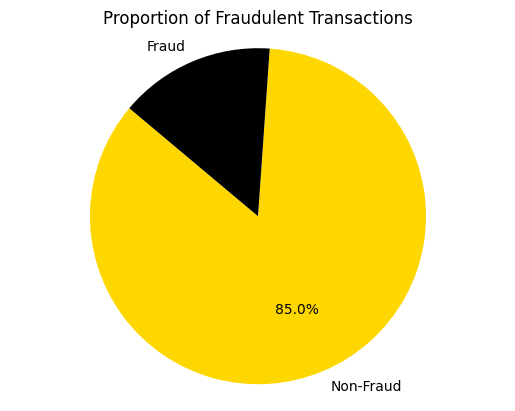

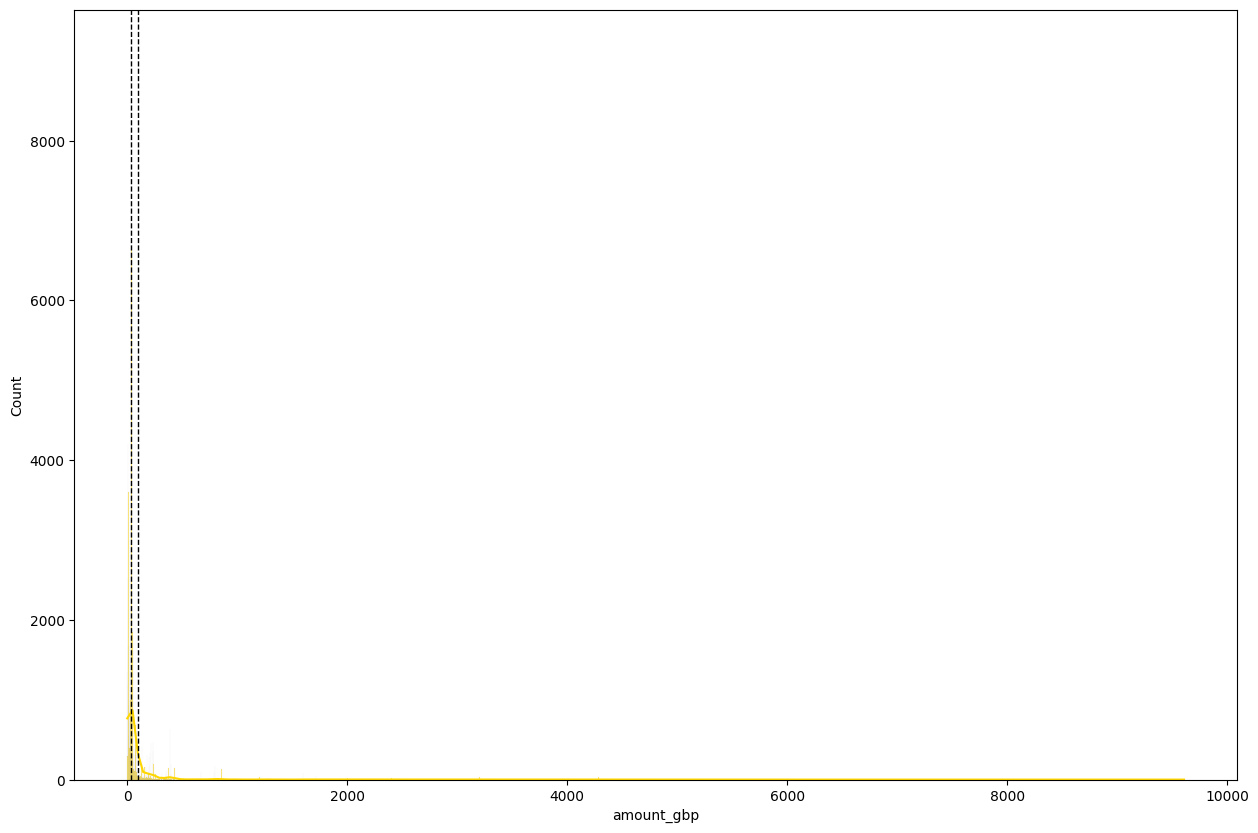

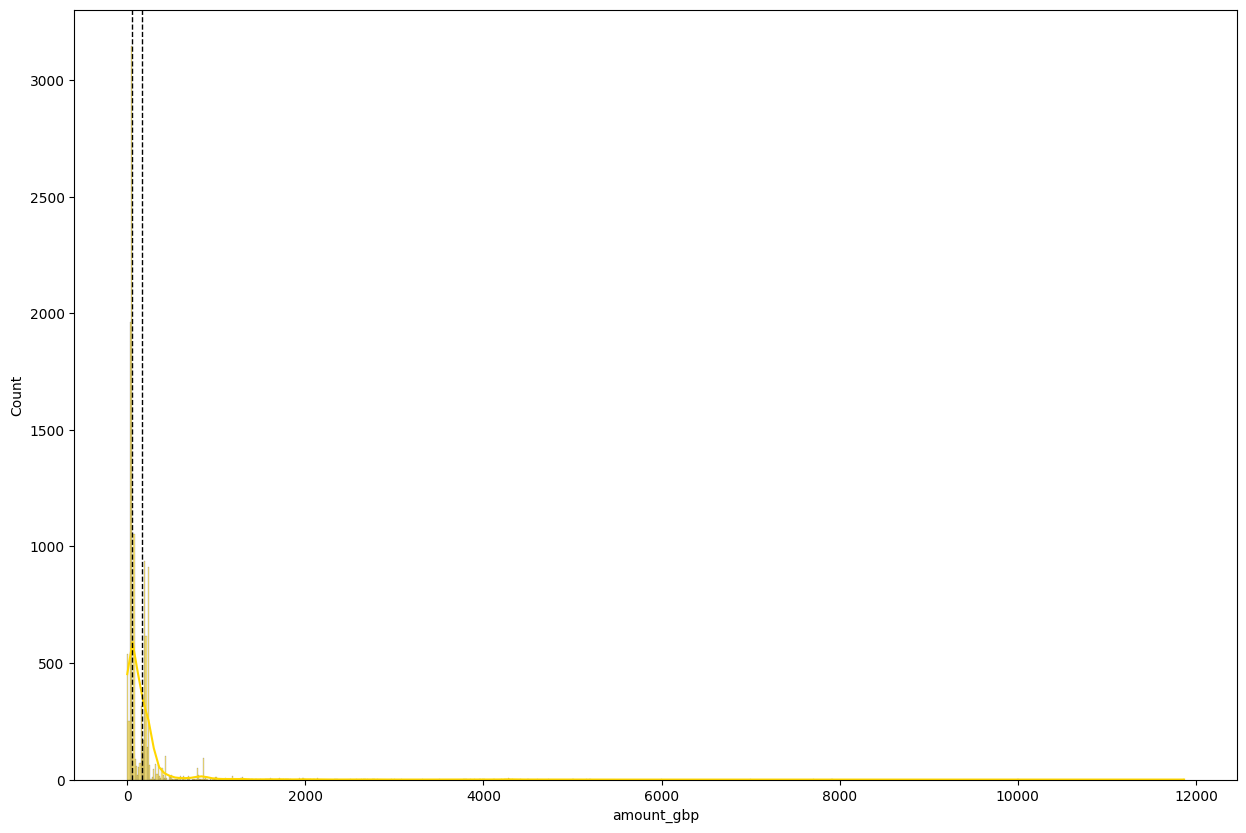

In [6]:
#Look into share of fradulent trx vs non-fraudulent
Data_Adf["Is_fraud"].value_counts().plot.pie(labels=['Non-Fraud','Fraud'],colors=['gold','black'], autopct='%1.1f%%',startangle=140,textprops={'color':"black"})
plt.title('Proportion of Fraudulent Transactions')
plt.ylabel('')
plt.axis('equal')
plt.show()

#Check Amount distribution of Fraudulent Vs non Fraudulent Trx
fraudulent_df = Data_Adf[Data_Adf["Is_fraud"]==True]
non_fraudulent_df = Data_Adf[Data_Adf["Is_fraud"]==False]

#Trx_amount_gbp
plt.figure(figsize=(15,10))
sns.histplot(non_fraudulent_df["amount_gbp"], kde=True, color='gold', edgecolor='black')
mean_value = np.mean(non_fraudulent_df["amount_gbp"])
median_value = np.median(non_fraudulent_df["amount_gbp"])
plt.axvline(mean_value, color='black', linestyle='dashed', linewidth=1)
plt.axvline(median_value, color='black', linestyle='dashed', linewidth=1)
plt.show()


plt.figure(figsize=(15,10))
sns.histplot(fraudulent_df["amount_gbp"], kde=True, color='gold', edgecolor='black')
mean_value = np.mean(fraudulent_df["amount_gbp"])
median_value = np.median(fraudulent_df["amount_gbp"])
plt.axvline(mean_value, color='black', linestyle='dashed', linewidth=1)
plt.axvline(median_value, color='black', linestyle='dashed', linewidth=1)
plt.show()

#Generate Customer Profiles (Cust_Profiles)

In [7]:
#Calcualte Customer Profile Statistics
cust_profiles = Data_Adf.groupby('Clientinfo_id')['amount_gbp'].agg(['mean','median']).reset_index()
cust_profiles.columns = ['client_id','cust_profiles_mean_gbp_amount','cust_profiles_median_gbp_amount']
cust_profiles_std = Data_Adf.groupby('Clientinfo_id')['amount_gbp'].std(ddof=0).reset_index()
cust_profiles_std.columns = ['client_id','cust_profiles_std_gbp_amount']


#Calcualte Average Number of Trx
Data_Adf['timestamp'] = pd.to_datetime(Data_Adf['timestamp'],errors='coerce')
trx_per_day_per_customer = Data_Adf.groupby(['Clientinfo_id', Data_Adf['timestamp'].dt.date]).size().reset_index(name='num_transactions')
mean_nb_trx_per_day = trx_per_day_per_customer.groupby('Clientinfo_id')['num_transactions'].mean().reset_index()
mean_nb_trx_per_day.columns = ['client_id','cust_profiles_mean_nb_trx_per_day']

#Merge Datasets to one
Cust_Profiles = pd.merge(cust_profiles,cust_profiles_std,on='client_id')
Cust_Profiles = pd.merge(cust_profiles,mean_nb_trx_per_day,on='client_id')

#Cust_Profiles_Data
Cust_Profiles

,client_id,cust_profiles_mean_gbp_amount,cust_profiles_median_gbp_amount,cust_profiles_mean_nb_trx_per_day
0,1058555,53.650,53.650,1.0
1,1058557,53.650,53.650,1.0
2,1058568,157.750,157.750,1.0
3,1058569,157.750,157.750,1.0
4,1058596,137.735,137.735,1.0
...,...,...,...,...
23216,4641129,320.260,320.260,1.0
23217,4641576,213.500,213.500,1.0
23218,4641854,70.460,70.460,1.0
23219,4643042,55.250,55.250,1.0


# Get Customer Country from IP Address / Card Info (Cust_Country_Profile)

In [8]:
def get_country(ip):
    mmdb_file_path = '/content/drive/MyDrive/CAS_Final_Project/GeoLite2-City.mmdb'

    if pd.notna(ip) and ip != 'nan':
        try:
            with geoip2.database.Reader(mmdb_file_path) as reader:
                response = reader.city(ip)

                country_name = response.country.name
                country_iso_code = response.country.iso_code
                return country_name, country_iso_code
        except Exception as e:
            return 0, 0
    else:
        return 0, 0

df_Country_lan_lat = pd.read_csv("/content/drive/MyDrive/CAS_Final_Project/Country_lan_lat.csv",sep=';')

In [9]:
#Get Customer Device IP Coordinates (Country)
Cust_Country_Profile_Ip = Data_Adf[['id','Clientinfo_id','Deviceinfo_ip']].copy()
Cust_Country_Profile_Ip['Deviceinfo_ip'] = Cust_Country_Profile_Ip['Deviceinfo_ip'].astype(str)
Cust_Country_Profile_Ip[['country_name','country']] = Cust_Country_Profile_Ip['Deviceinfo_ip'].apply(lambda x:  pd.Series(get_country(x)))

merge_df = pd.merge(Cust_Country_Profile_Ip,df_Country_lan_lat,on='country',how='left')

columns_to_keep = ['id','Clientinfo_id','latitude','longitude']
Cust_Country_Profile_Ip = merge_df[columns_to_keep]

old_colums_names = ['id','Clientinfo_id','latitude','longitude']
new_columns_names = ['id','client_id','latitude_ip','longitude_ip']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Cust_Country_Profile_Ip = Cust_Country_Profile_Ip.rename(columns=new_columns_dic)
Cust_Country_Profile_Ip

,id,client_id,latitude_ip,longitude_ip
0,11240071,4456848,52.132633,5.291266
1,10009295,3957345,61.924110,25.748151
2,2289429,1182146,NaN,NaN
3,2518170,1182146,NaN,NaN
4,2356966,1253728,NaN,NaN
...,...,...,...,...
77215,10511015,4237488,37.090240,-95.712891
77216,8339899,3221974,18.109581,-77.297508
77217,9314684,3874235,37.090240,-95.712891
77218,7654638,3228049,37.090240,-95.712891


In [10]:
#Get Customer Card Issuer Bank Coordinates (Country)
Card_Info_Country_Profile = Data_Adf[['id','Clientinfo_id','Countries_iso2']].copy()
Card_Info_Country_Profile = Card_Info_Country_Profile.fillna(0)
old_colums_names = ['Countries_iso2']
new_columns_names = ['country']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Card_Info_Country_Profile = Card_Info_Country_Profile.rename(columns=new_columns_dic)
merge_df = pd.merge(Card_Info_Country_Profile,df_Country_lan_lat,on='country',how='left')
columns_to_keep = ['id','Clientinfo_id','latitude','longitude']
Card_Info_Country_Profile = merge_df[columns_to_keep]
old_colums_names = ['id','Clientinfo_id','latitude','longitude']
new_columns_names = ['id','client_id','latitude_card','longitude_card']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Card_Info_Country_Profile = Card_Info_Country_Profile.rename(columns=new_columns_dic)
Card_Info_Country_Profile

,id,client_id,latitude_card,longitude_card
0,11240071,4456848,52.132633,5.291266
1,10009295,3957345,61.924110,25.748151
2,2289429,1182146,NaN,NaN
3,2518170,1182146,NaN,NaN
4,2356966,1253728,NaN,NaN
...,...,...,...,...
77215,10511015,4237488,37.090240,-95.712891
77216,8339899,3221974,37.090240,-95.712891
77217,9314684,3874235,37.090240,-95.712891
77218,7654638,3228049,37.090240,-95.712891


In [11]:
#Customer Country Coordinates (Final)
merge_df = pd.merge(Cust_Country_Profile_Ip,Card_Info_Country_Profile,how = 'left', on='id')
print(len(merge_df))
merge_df.columns
columns_to_keep = ['id', 'client_id_x', 'latitude_ip', 'longitude_ip','latitude_card', 'longitude_card']
Cust_Country_Profile = merge_df[columns_to_keep]
Cust_Country_Profile.columns

old_colums_names = ['id', 'client_id_x', 'latitude_ip', 'longitude_ip', 'latitude_card','longitude_card']
new_columns_names = ['id', 'client_id', 'latitude_ip', 'longitude_ip', 'latitude_card','longitude_card']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Cust_Country_Profile = Cust_Country_Profile.rename(columns=new_columns_dic)

Cust_Country_Profile.set_index('id',inplace=True)
Cust_Country_Profile.index = Cust_Country_Profile.index.astype(int)
Cust_Country_Profile

77220


,client_id,latitude_ip,longitude_ip,latitude_card,longitude_card
id,,,,,
11240071,4456848,52.132633,5.291266,52.132633,5.291266
10009295,3957345,61.924110,25.748151,61.924110,25.748151
2289429,1182146,NaN,NaN,NaN,NaN
2518170,1182146,NaN,NaN,NaN,NaN
2356966,1253728,NaN,NaN,NaN,NaN
...,...,...,...,...,...
10511015,4237488,37.090240,-95.712891,37.090240,-95.712891
8339899,3221974,18.109581,-77.297508,37.090240,-95.712891
9314684,3874235,37.090240,-95.712891,37.090240,-95.712891


# Get Transaction Profile (Trx_Profile)

In [12]:
def time_to_seconds(t):
    return t.hour * 3600 + t.minute * 60 + t.second

def is_weekend(date):
    return date.weekday() >= 5

def get_client_spending_behaviour_features(customer_trx, window_size_in_days = [1,7,30]):

  customer_trx = customer_trx.sort_values('timestamp')
  customer_trx.index = customer_trx.timestamp

  for window_size in window_size_in_days:
    sum_amount_trx_window = customer_trx['amount_gbp'].rolling(str(window_size)+'d').sum()
    nb_trx_window = customer_trx['amount_gbp'].rolling(str(window_size) + 'd').count()

    avg_amount_trx_window = sum_amount_trx_window/nb_trx_window

    customer_trx['client_nb_trx_' + str(window_size) + 'day_window'] = list(nb_trx_window)
    customer_trx['client_avg_amount_'+str(window_size) + 'day_window'] = list(avg_amount_trx_window)

  customer_trx.index = customer_trx.id

  return customer_trx

#Trx Profiles table
Trx_Profile = Data_Adf[['id','timestamp','Clientinfo_id','amount_gbp']].copy()
Trx_Profile.loc[:,'time'] = Trx_Profile['timestamp'].dt.time
Trx_Profile.loc[:,'trx_time_seconds'] = Trx_Profile['time'].apply(lambda x: time_to_seconds(x))
Trx_Profile.loc[:,'date'] = Trx_Profile['timestamp'].dt.date
Trx_Profile.loc[:,'is_WKE?'] = Trx_Profile['date'].apply(lambda x: is_weekend(x)).astype(int)

target_time = pd.to_datetime('22:00:00').time()
Trx_Profile.loc[:,'is_night?'] = (Trx_Profile['time'] > target_time).astype(int)


columns_to_drop = ['time','date']
Trx_Profile = Trx_Profile.drop(columns=columns_to_drop)
old_colums_names = Trx_Profile.columns
new_columns_names = ['id','timestamp','client_id','trx_amount_gbp','trx_time_seconds','trx_is_weekend']
new_columns_dic = {k: v for k, v in zip(old_colums_names,new_columns_names)}

Trx_Profile = Trx_Profile.rename(columns=new_columns_dic)

Trx_Profile.set_index('id',inplace=True)
Trx_Profile.index = Trx_Profile.index.astype(int)
Trx_Profile

,timestamp,client_id,trx_amount_gbp,trx_time_seconds,trx_is_weekend,is_night?
id,,,,,,
11240071,2024-03-25 13:24:14+00:00,4456848,369.52,48254,0,0
10009295,2023-11-13 10:56:26+00:00,3957345,112.33,39386,0,0
2289429,2021-02-11 14:25:39+00:00,1182146,800.77,51939,0,0
2518170,2021-03-22 15:48:13+00:00,1182146,2402.31,56893,0,0
2356966,2021-02-24 16:56:01+00:00,1253728,0.02,60961,0,0
...,...,...,...,...,...,...
10511015,2024-01-04 18:12:30+00:00,4237488,39.56,65550,0,0
8339899,2023-05-22 15:35:15+00:00,3221974,76.00,56115,0,0
9314684,2023-08-25 00:33:15+00:00,3874235,80.00,1995,0,0


# Get Customer Behavoiur Profile (Trx_Profile_Rolling)

In [13]:
#Customer Behaviour Profile
Trx_Profile_Rolling = Data_Adf[['id','timestamp','Clientinfo_id','amount_gbp']].copy()

Trx_Profile_Rolling['timestamp'] = Trx_Profile_Rolling['timestamp'].dt.tz_localize(None)
Trx_Profile_Rolling['timestamp'] = Trx_Profile_Rolling['timestamp'].astype('datetime64[ns]')

Trx_Profile_Rolling = Trx_Profile_Rolling.sort_values(['timestamp','Clientinfo_id'], ascending=[True,True],ignore_index=True)

%time Trx_Profile_Rolling = Trx_Profile_Rolling.groupby('Clientinfo_id').apply(lambda x: get_client_spending_behaviour_features(x))

Trx_Profile_Rolling.set_index('id',inplace=True)
Trx_Profile_Rolling.index = Trx_Profile_Rolling.index.astype(int)
Trx_Profile_Rolling

CPU times: user 1min 45s, sys: 1.85 s, total: 1min 47s
Wall time: 1min 46s


,timestamp,Clientinfo_id,amount_gbp,client_nb_trx_1day_window,client_avg_amount_1day_window,client_nb_trx_7day_window,client_avg_amount_7day_window,client_nb_trx_30day_window,client_avg_amount_30day_window
id,,,,,,,,,
1983485,2021-01-01 00:01:07,1058555,53.65,1.0,53.65,1.0,53.65,1.0,53.65
1983490,2021-01-01 00:08:21,1058557,53.65,1.0,53.65,1.0,53.65,1.0,53.65
1983522,2021-01-01 00:37:17,1058568,157.75,1.0,157.75,1.0,157.75,1.0,157.75
1983524,2021-01-01 00:38:50,1058569,157.75,1.0,157.75,1.0,157.75,1.0,157.75
1983596,2021-01-01 01:57:49,1058596,37.64,1.0,37.64,1.0,37.64,1.0,37.64
...,...,...,...,...,...,...,...,...,...
11584431,2024-04-30 12:20:58,4641129,320.26,1.0,320.26,1.0,320.26,1.0,320.26
11585569,2024-04-30 14:09:47,4641576,213.50,1.0,213.50,1.0,213.50,1.0,213.50
11586445,2024-04-30 15:22:20,4641854,70.46,1.0,70.46,1.0,70.46,1.0,70.46


# Get Merchant Brand Profile (Brand_Fraud_Profile)

In [14]:
def get_count_risk_rolling_window(terminal_trx, delay_period = 7, windows_size_in_days = [1, 7, 30], feature = "Terminal_ID"):

  terminal_trx = terminal_trx.sort_values('timestamp')
  terminal_trx.index = terminal_trx.timestamp

  for window_size in windows_size_in_days:
   sum_amount_fraud_trx_window = terminal_trx['amount_gbp_fraud_trx'].rolling(str(window_size) + 'd').sum()
   nb_fraud_trx_window = terminal_trx['amount_gbp_fraud_trx'].rolling(str(window_size) + 'd').count()

   avg_amount_fraud_trx = sum_amount_fraud_trx_window / nb_fraud_trx_window

   terminal_trx['brand_fraud_nb_trx_' + str(window_size) + 'day_window'] = list(nb_fraud_trx_window)
   terminal_trx['brand_fraud_avg_amount_'+str(window_size) + 'day_window'] = list(avg_amount_fraud_trx)

  terminal_trx.index = terminal_trx.id

  return terminal_trx

Data_Adf['Is_fraud'] = Data_Adf['Is_fraud'].astype(bool)
Data_Adf['amount_gbp_fraud_trx'] = Data_Adf['amount_gbp'].where(Data_Adf['Is_fraud'], np.nan)

Brand_Fraud_Profile = Data_Adf[['id','timestamp','Brands_id','amount_gbp_fraud_trx']].copy()

Brand_Fraud_Profile['timestamp'] = Brand_Fraud_Profile['timestamp'].dt.tz_localize(None)
Brand_Fraud_Profile['timestamp'] = Brand_Fraud_Profile['timestamp'].astype('datetime64[ns]')

Brand_Fraud_Profile = Brand_Fraud_Profile.sort_values(['timestamp','Brands_id'], ascending=[True,True],ignore_index=True)

%time Brand_Fraud_Profile = Brand_Fraud_Profile.groupby('Brands_id').apply(lambda x: get_count_risk_rolling_window(x))

Brand_Fraud_Profile.set_index('id')

Brand_Fraud_Profile

Brand_Fraud_Profile.set_index('id',inplace=True)

Brand_Fraud_Profile.index = Brand_Fraud_Profile.index.astype(int)

Brand_Fraud_Profile = Brand_Fraud_Profile.drop('amount_gbp_fraud_trx', axis=1)

Brand_Fraud_Profile

CPU times: user 1.66 s, sys: 13.5 ms, total: 1.67 s
Wall time: 1.67 s


,timestamp,Brands_id,brand_fraud_nb_trx_1day_window,brand_fraud_avg_amount_1day_window,brand_fraud_nb_trx_7day_window,brand_fraud_avg_amount_7day_window,brand_fraud_nb_trx_30day_window,brand_fraud_avg_amount_30day_window
id,,,,,,,,
1989686,2021-01-02 18:18:00,1234,1.0,53.65,1.0,53.6500,1.0,53.6500
1999498,2021-01-04 21:42:57,1234,1.0,157.75,2.0,105.7000,2.0,105.7000
2001827,2021-01-05 09:31:50,1234,2.0,105.70,3.0,88.3500,3.0,88.3500
2103691,2021-01-06 21:50:25,1234,1.0,45.64,4.0,77.6725,4.0,77.6725
2121615,2021-01-09 07:47:44,1234,1.0,53.65,5.0,72.8680,5.0,72.8680
...,...,...,...,...,...,...,...,...
11589186,2024-04-30 21:00:16,851571,0.0,NaN,0.0,NaN,0.0,NaN
11589201,2024-04-30 21:02:30,851571,0.0,NaN,0.0,NaN,0.0,NaN
11589214,2024-04-30 21:04:39,851571,0.0,NaN,0.0,NaN,0.0,NaN


# Get All Dummy Variables (Data_Dummies)

In [15]:
# creating a copy of the original data frame and adding a few columns
Data_Dummies = Data_Adf[['id','Currency_name','Environments_name','Brands_name','Deviceinfo_device_name','Deviceinfo_browser_name','Clientinfo_email','Paymentbrands_name','Issuers_name','Industries_name','Companies_name','Processors_name']].copy()
Data_Dummies['Email_domain'] = Data_Dummies['Clientinfo_email'].str.split('@').str[1].str.split('.').str[0]
Data_Dummies = Data_Dummies.replace(' ', '_', regex=True)

#Creating all dummy variables
Data_Dummies = pd.get_dummies(Data_Dummies,columns=['Currency_name','Environments_name','Brands_name','Deviceinfo_device_name','Deviceinfo_browser_name','Email_domain','Paymentbrands_name','Issuers_name','Industries_name','Companies_name','Processors_name'])
Data_Dummies = Data_Dummies.drop(columns='Clientinfo_email')
Data_Dummies = Data_Dummies.astype(int)

Data_Dummies.set_index('id', inplace=True)
Data_Dummies

,Currency_name_AUD,Currency_name_CAD,Currency_name_CHF,Currency_name_CZK,Currency_name_EUR,Currency_name_GBP,Currency_name_INR,Currency_name_MYR,Currency_name_RUB,Currency_name_USD,...,Companies_name_xShop_OU,Companies_name_xrg3olb_OU,Processors_name_CCD,Processors_name_CTM,Processors_name_ECP,Processors_name_LPB,Processors_name_NUV,Processors_name_PNC,Processors_name_TRU,Processors_name_WLN
id,,,,,,,,,,,,,,,,,,,,,
11240071,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10009295,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2289429,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2518170,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2356966,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10511015,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
8339899,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9314684,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# Combine Everything to a Single Dataset

In [16]:
# Rest indexs in all dataframes in preparation to merge
Cust_Profiles #Key is Client id
Cust_Country_Profile = Cust_Country_Profile.reset_index(level='id') #Key is id
Trx_Profile = Trx_Profile.reset_index(level='id') #Key is id
Trx_Profile_Rolling = Trx_Profile_Rolling.reset_index(level='id') #Key is id
Brand_Fraud_Profile = Brand_Fraud_Profile.reset_index(level='id') #Key is id

In [17]:
#Merge all datasets to a single dataset
DF_Flag = Data_Adf[['id', 'Is_fraud']]
DF_Flag.loc[:, 'id'] = DF_Flag['id'].astype(int)
DF = pd.merge(Cust_Country_Profile, DF_Flag, how='left', on='id')
DF['Is_fraud'] = DF['Is_fraud'].astype(int)

DF1 = pd.merge(DF, Trx_Profile, how='left', on='id')
DF2 = pd.merge(DF1, Trx_Profile_Rolling,how='left',on='id')
DF3 = pd.merge(DF2, Brand_Fraud_Profile,how='left',on='id')

##Without Dummies

In [18]:
DF4 = pd.merge(DF3, Cust_Profiles, how='left', left_on='client_id_x', right_on='client_id')

#Gather columns containing ID's and other unnecessary columns to drop and drop them
column_ids = [col for col in DF4.columns if '_id' in col]
column_timestamp = [col for col in DF4.columns if 'timestamp' in col]
columns_amount = [col for col in DF4.columns if 'amount' in col]
dropcolumns = column_ids + column_timestamp + ['id'] + ['trx_amount_gbp']+ ['latitude_ip']+ ['longitude_ip']+ ['latitude_card']+ ['longitude_card']

DF_ready = DF4.drop(columns = dropcolumns)
DF_ready

,Is_fraud,trx_time_seconds,trx_is_weekend,is_night?,amount_gbp,client_nb_trx_1day_window,client_avg_amount_1day_window,client_nb_trx_7day_window,client_avg_amount_7day_window,client_nb_trx_30day_window,client_avg_amount_30day_window,brand_fraud_nb_trx_1day_window,brand_fraud_avg_amount_1day_window,brand_fraud_nb_trx_7day_window,brand_fraud_avg_amount_7day_window,brand_fraud_nb_trx_30day_window,brand_fraud_avg_amount_30day_window,cust_profiles_mean_gbp_amount,cust_profiles_median_gbp_amount,cust_profiles_mean_nb_trx_per_day
0,0,48254,0,0,369.52,1.0,369.520,2.0,377.630000,3.0,412.780000,0.0,NaN,2.0,278.96,3.0,257.503333,412.780000,385.740,1.000000
1,0,39386,0,0,112.33,1.0,112.330,1.0,112.330000,2.0,121.765000,0.0,NaN,0.0,NaN,0.0,NaN,182.407143,133.670,1.000000
2,0,51939,0,0,800.77,1.0,800.770,1.0,800.770000,4.0,1201.155000,0.0,NaN,0.0,NaN,2.0,196.185000,1241.193000,1281.230,1.000000
3,0,56893,0,0,2402.31,1.0,2402.310,2.0,1881.810000,3.0,1868.463333,0.0,NaN,0.0,NaN,0.0,NaN,1241.193000,1281.230,1.000000
4,0,60961,0,0,0.02,5.0,0.020,23.0,0.393913,23.0,0.393913,0.0,NaN,0.0,NaN,2.0,196.185000,0.348923,0.020,2.954545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77215,0,65550,0,0,39.56,2.0,59.345,2.0,59.345000,2.0,59.345000,0.0,NaN,2.0,118.69,7.0,350.417143,59.345000,59.345,2.000000
77216,0,56115,0,0,76.00,1.0,76.000,1.0,76.000000,1.0,76.000000,0.0,NaN,1.0,1152.00,2.0,656.000000,76.000000,76.000,1.000000
77217,0,1995,0,0,80.00,1.0,80.000,1.0,80.000000,1.0,80.000000,0.0,NaN,0.0,NaN,0.0,NaN,80.000000,80.000,1.000000
77218,0,53680,0,0,4608.00,1.0,4608.000,1.0,4608.000000,1.0,4608.000000,0.0,NaN,0.0,NaN,0.0,NaN,2441.600000,2441.600,1.000000


##With Dummies

In [19]:
DF4_d = pd.merge(DF3, Data_Dummies, how='left', on='id')
DF5_d = pd.merge(DF4_d, Cust_Profiles, how='left', left_on='client_id_x', right_on='client_id')

#Gather columns containing ID's and other unnecessary columns to drop and drop them
column_ids = [col for col in DF5_d.columns if '_id' in col]
column_timestamp = [col for col in DF5_d.columns if 'timestamp' in col]
columns_amount = [col for col in DF5_d.columns if 'amount' in col]
dropcolumns = column_ids + column_timestamp + ['id'] + ['trx_amount_gbp']

DF_ready_d = DF5_d.drop(columns = dropcolumns)
DF_ready_d

,latitude_ip,longitude_ip,latitude_card,longitude_card,Is_fraud,trx_time_seconds,trx_is_weekend,is_night?,amount_gbp,client_nb_trx_1day_window,...,Processors_name_CTM,Processors_name_ECP,Processors_name_LPB,Processors_name_NUV,Processors_name_PNC,Processors_name_TRU,Processors_name_WLN,cust_profiles_mean_gbp_amount,cust_profiles_median_gbp_amount,cust_profiles_mean_nb_trx_per_day
0,52.132633,5.291266,52.132633,5.291266,0,48254,0,0,369.52,1.0,...,0,0,0,0,1,0,0,412.780000,385.740,1.000000
1,61.924110,25.748151,61.924110,25.748151,0,39386,0,0,112.33,1.0,...,0,0,0,0,1,0,0,182.407143,133.670,1.000000
2,NaN,NaN,NaN,NaN,0,51939,0,0,800.77,1.0,...,0,0,1,0,0,0,0,1241.193000,1281.230,1.000000
3,NaN,NaN,NaN,NaN,0,56893,0,0,2402.31,1.0,...,0,0,1,0,0,0,0,1241.193000,1281.230,1.000000
4,NaN,NaN,NaN,NaN,0,60961,0,0,0.02,5.0,...,0,0,1,0,0,0,0,0.348923,0.020,2.954545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77215,37.090240,-95.712891,37.090240,-95.712891,0,65550,0,0,39.56,2.0,...,0,0,0,0,1,0,0,59.345000,59.345,2.000000
77216,18.109581,-77.297508,37.090240,-95.712891,0,56115,0,0,76.00,1.0,...,0,0,0,0,1,0,0,76.000000,76.000,1.000000
77217,37.090240,-95.712891,37.090240,-95.712891,0,1995,0,0,80.00,1.0,...,0,0,0,0,1,0,0,80.000000,80.000,1.000000
77218,37.090240,-95.712891,37.090240,-95.712891,0,53680,0,0,4608.00,1.0,...,0,0,0,0,1,0,0,2441.600000,2441.600,1.000000


##Without Profiles

In [20]:
DF_x = pd.merge(Data_Dummies, DF_Flag, how='left', on='id')

#Gather columns containing ID's and other unnecessary columns to drop and drop them
column_ids = [col for col in DF_x.columns if '_id' in col]
column_timestamp = [col for col in DF_x.columns if 'timestamp' in col]
columns_amount = [col for col in DF_x.columns if 'amount' in col]
dropcolumns = column_ids + column_timestamp + ['id']

DF_ready_x = DF_x.drop(columns = dropcolumns)
DF_ready_x

,Currency_name_AUD,Currency_name_CAD,Currency_name_CHF,Currency_name_CZK,Currency_name_EUR,Currency_name_GBP,Currency_name_INR,Currency_name_MYR,Currency_name_RUB,Currency_name_USD,...,Companies_name_xrg3olb_OU,Processors_name_CCD,Processors_name_CTM,Processors_name_ECP,Processors_name_LPB,Processors_name_NUV,Processors_name_PNC,Processors_name_TRU,Processors_name_WLN,Is_fraud
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,False
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,False
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,False
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,False
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77215,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,False
77216,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,False
77217,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,False
77218,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,False


# Get Balanced Dataset

In [21]:
# Select subset with non-null & null values
# Removing duplicate rows based on the 'id' column
# ones_subset = DF_ready.loc[DF_ready["Is_fraud"] == 1]
# zeros_subset = DF_ready.loc[DF_ready["Is_fraud"] == 0]
# ones_subset = DF_ready_x.loc[DF_ready_x["Is_fraud"] == 1]
# zeros_subset = DF_ready_x.loc[DF_ready_x["Is_fraud"] == 0]
ones_subset = DF_ready_d.loc[DF_ready_d["Is_fraud"] == 1]
zeros_subset = DF_ready_d.loc[DF_ready_d["Is_fraud"] == 0]

# Count the number of non-null values & Sample null values to match the number of non-null values
number_of_ones = len(ones_subset)
sampled_zeros = zeros_subset.sample(number_of_ones, random_state=42)

# Concatenate the sampled null values with the non-null values
balanced_df = pd.concat([ones_subset, sampled_zeros], ignore_index=True)

#Copy Dataset & account for Null Values
DS = balanced_df.copy()
DS.replace('<NA>', np.nan, inplace=True)

DS

,latitude_ip,longitude_ip,latitude_card,longitude_card,Is_fraud,trx_time_seconds,trx_is_weekend,is_night?,amount_gbp,client_nb_trx_1day_window,...,Processors_name_CTM,Processors_name_ECP,Processors_name_LPB,Processors_name_NUV,Processors_name_PNC,Processors_name_TRU,Processors_name_WLN,cust_profiles_mean_gbp_amount,cust_profiles_median_gbp_amount,cust_profiles_mean_nb_trx_per_day
0,9.748917,-83.753428,NaN,NaN,1,74862,0,0,790.36,1.0,...,0,0,0,0,0,0,1,790.360000,790.360,1.000000
1,NaN,NaN,31.046051,34.851612,1,51995,0,0,1355.24,1.0,...,0,1,0,0,0,0,0,1355.240000,1355.240,1.000000
2,NaN,NaN,NaN,NaN,1,48145,0,0,470.51,1.0,...,0,1,0,0,0,0,0,470.510000,470.510,1.000000
3,NaN,NaN,NaN,NaN,1,66681,0,0,213.40,1.0,...,0,1,0,0,0,0,0,213.400000,213.400,1.000000
4,NaN,NaN,NaN,NaN,1,32445,0,0,214.26,1.0,...,0,0,0,0,0,0,1,428.515000,428.515,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23159,37.090240,-95.712891,37.090240,-95.712891,0,16195,0,0,11.86,1.0,...,0,1,0,0,0,0,0,14.224458,11.860,1.360656
23160,1.352083,103.819836,56.130366,-106.346771,0,61316,0,0,186.91,1.0,...,0,0,0,0,0,0,1,186.910000,186.910,1.000000
23161,37.090240,-95.712891,37.090240,-95.712891,0,43942,1,0,4.74,3.0,...,0,1,0,0,0,0,0,5.554672,4.740,1.867925
23162,55.378051,-3.435973,37.090240,-95.712891,0,36546,0,0,49.99,1.0,...,0,1,0,0,0,0,0,51.272051,49.990,1.026316


# Extract Target Variable



In [22]:
# Extract target variable and drop unnecessary columns
y = DS['Is_fraud']
X = DS.drop(columns=['Is_fraud'])

# Replace NaN with zeroes
X = X.fillna(0)

X

,latitude_ip,longitude_ip,latitude_card,longitude_card,trx_time_seconds,trx_is_weekend,is_night?,amount_gbp,client_nb_trx_1day_window,client_avg_amount_1day_window,...,Processors_name_CTM,Processors_name_ECP,Processors_name_LPB,Processors_name_NUV,Processors_name_PNC,Processors_name_TRU,Processors_name_WLN,cust_profiles_mean_gbp_amount,cust_profiles_median_gbp_amount,cust_profiles_mean_nb_trx_per_day
0,9.748917,-83.753428,0.000000,0.000000,74862,0,0,790.36,1.0,790.36,...,0,0,0,0,0,0,1,790.360000,790.360,1.000000
1,0.000000,0.000000,31.046051,34.851612,51995,0,0,1355.24,1.0,1355.24,...,0,1,0,0,0,0,0,1355.240000,1355.240,1.000000
2,0.000000,0.000000,0.000000,0.000000,48145,0,0,470.51,1.0,470.51,...,0,1,0,0,0,0,0,470.510000,470.510,1.000000
3,0.000000,0.000000,0.000000,0.000000,66681,0,0,213.40,1.0,213.40,...,0,1,0,0,0,0,0,213.400000,213.400,1.000000
4,0.000000,0.000000,0.000000,0.000000,32445,0,0,214.26,1.0,214.26,...,0,0,0,0,0,0,1,428.515000,428.515,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23159,37.090240,-95.712891,37.090240,-95.712891,16195,0,0,11.86,1.0,11.86,...,0,1,0,0,0,0,0,14.224458,11.860,1.360656
23160,1.352083,103.819836,56.130366,-106.346771,61316,0,0,186.91,1.0,186.91,...,0,0,0,0,0,0,1,186.910000,186.910,1.000000
23161,37.090240,-95.712891,37.090240,-95.712891,43942,1,0,4.74,3.0,4.74,...,0,1,0,0,0,0,0,5.554672,4.740,1.867925
23162,55.378051,-3.435973,37.090240,-95.712891,36546,0,0,49.99,1.0,49.99,...,0,1,0,0,0,0,0,51.272051,49.990,1.026316


# Logistic Regression Model

In [23]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform Robust Scaling as normalization method (left skewed)
scaler = RobustScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize PCA to keep 95% of the variance
pca = PCA(n_components=None)

# Fit PCA on the scaled training data and transform both training and test data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train a Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_pca, y_train)

# Predict on the test set
y_pred = model.predict(X_test_pca)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2113  203]
 [  96 2221]]
              precision    recall  f1-score   support

           0       0.96      0.91      0.93      2316
           1       0.92      0.96      0.94      2317

    accuracy                           0.94      4633
   macro avg       0.94      0.94      0.94      4633
weighted avg       0.94      0.94      0.94      4633



In [24]:
# Get the coefficients of the logistic regression model
coefficients = model.coef_

# Get the principal components
components = pca.components_

# Map the coefficients back to the original features
feature_importance = np.dot(coefficients, components)

# Analyze the feature importance
feature_importance_abs = np.abs(feature_importance)
sorted_indices = np.argsort(feature_importance_abs)[0][::-1]  # Sort indices by absolute magnitude

# Print the top N features
top_n = 10  # Change this value according to your preference
for i in range(top_n):
    feature_index = sorted_indices[i]
    feature_name = X.columns[feature_index]  # Assuming X is a DataFrame
    importance_score = feature_importance[0][feature_index]
    print(f"Feature: {feature_name}, Importance Score: {importance_score}")


Feature: Issuers_name_CAPITAL_ONE_(EUROPE)_PLC, Importance Score: 3.791680809944482
Feature: Issuers_name_HONG_LEONG_BANK_BERHAD, Importance Score: 3.77102218284921
Feature: Deviceinfo_device_name_Samsung_SM-A037U, Importance Score: 2.3771982841672057
Feature: Issuers_name_BNP_PARIBAS, Importance Score: 2.191841415857427
Feature: Issuers_name_NATIONWIDE_BUILDING_SOCIETY, Importance Score: 2.0048086838591432
Feature: Issuers_name_BANQUE_FEDERATIVE_DU_CREDIT_MUTUEL_(BFCM), Importance Score: 1.9107531376063416
Feature: Issuers_name_BARCLAYS_BANK_PLC., Importance Score: 1.894802114258301
Feature: Brands_name_1010_Labs, Importance Score: -1.891410754413782
Feature: Issuers_name_GREATER_BUILDING_SOCIETY,_LTD., Importance Score: 1.8723363800710175
Feature: Issuers_name_CAISSE_NATIONALE_DES_CAISSES_D'EPARGNE_(CNCE), Importance Score: 1.8198986994021056


In [25]:
# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Get the indices of the top contributors
top_contributors_indices = np.argsort(explained_variance_ratio)[::-1][:10]

# Print the top contributors along with their percentages of variance explained
print("Top 10 Contributors:")
for i, idx in enumerate(top_contributors_indices):
    print(f"Component {i+1}: Variance Explained: {explained_variance_ratio[idx]*100:.2f}%")


Top 10 Contributors:
Component 1: Variance Explained: 63.41%
Component 2: Variance Explained: 14.84%
Component 3: Variance Explained: 5.82%
Component 4: Variance Explained: 3.51%
Component 5: Variance Explained: 1.54%
Component 6: Variance Explained: 1.34%
Component 7: Variance Explained: 1.13%
Component 8: Variance Explained: 0.99%
Component 9: Variance Explained: 0.72%
Component 10: Variance Explained: 0.53%


In [26]:
# Get the first principal component's eigenvector
first_component = pca.components_[0]

# Create a DataFrame to display the component along with their corresponding feature names
component_df = pd.DataFrame({'Feature': X.columns, 'Component Weight': first_component})

# Sort the DataFrame by absolute component weights to visualize the most influential features
component_df['Absolute Weight'] = np.abs(component_df['Component Weight'])
component_df = component_df.sort_values(by='Absolute Weight', ascending=False)

print("Components of Component 1:")
print(component_df)


Components of Component 1:
                              Feature  Component Weight  Absolute Weight
9       client_avg_amount_1day_window          0.382837         0.382837
11      client_avg_amount_7day_window          0.377459         0.377459
13     client_avg_amount_30day_window          0.372649         0.372649
3896  cust_profiles_median_gbp_amount          0.362370         0.362370
7                          amount_gbp          0.348824         0.348824
...                               ...               ...              ...
2080             Email_domain_sprynet          0.000000         0.000000
2849        Issuers_name_ENVISTA_C.U.          0.000000         0.000000
2844       Issuers_name_EML_MONEY_DAC          0.000000         0.000000
2061                Email_domain_siol          0.000000         0.000000
1435              Email_domain_9round          0.000000         0.000000

[3898 rows x 3 columns]


In [27]:
# Get the second principal component's eigenvector
second_component = pca.components_[1]

# Create a DataFrame to display the component along with their corresponding feature names
component_df2 = pd.DataFrame({'Feature': X.columns, 'Component Weight': second_component})

# Sort the DataFrame by absolute component weights to visualize the most influential features
component_df2['Absolute Weight'] = np.abs(component_df2['Component Weight'])
component_df2 = component_df2.sort_values(by='Absolute Weight', ascending=False)

print("Components of Component 2:")
print(component_df2)


Components of Component 2:
                                     Feature  Component Weight  \
10                 client_nb_trx_7day_window          0.781302   
12                client_nb_trx_30day_window          0.470065   
3897       cust_profiles_mean_nb_trx_per_day          0.341480   
8                  client_nb_trx_1day_window          0.171075   
16            brand_fraud_nb_trx_7day_window         -0.046079   
...                                      ...               ...   
1150  Deviceinfo_device_name_Samsung_SM-T585         -0.000000   
1149  Deviceinfo_device_name_Samsung_SM-T580         -0.000000   
1145  Deviceinfo_device_name_Samsung_SM-T515         -0.000000   
2871        Issuers_name_FIDELITY_BANK,_LTD.         -0.000000   
2811           Issuers_name_DIPOCKET_LIMITED         -0.000000   

      Absolute Weight  
10           0.781302  
12           0.470065  
3897         0.341480  
8            0.171075  
16           0.046079  
...               ...  
1150        

In [28]:
# Get the third principal component's eigenvector
third_component = pca.components_[2]

# Create a DataFrame to display the component along with their corresponding feature names
component_df3 = pd.DataFrame({'Feature': X.columns, 'Component Weight': second_component})

# Sort the DataFrame by absolute component weights to visualize the most influential features
component_df3['Absolute Weight'] = np.abs(component_df3['Component Weight'])
component_df3 = component_df3.sort_values(by='Absolute Weight', ascending=False)

print("Components of Component 3:")
print(component_df3)

Components of Component 3:
                                     Feature  Component Weight  \
10                 client_nb_trx_7day_window          0.781302   
12                client_nb_trx_30day_window          0.470065   
3897       cust_profiles_mean_nb_trx_per_day          0.341480   
8                  client_nb_trx_1day_window          0.171075   
16            brand_fraud_nb_trx_7day_window         -0.046079   
...                                      ...               ...   
1150  Deviceinfo_device_name_Samsung_SM-T585         -0.000000   
1149  Deviceinfo_device_name_Samsung_SM-T580         -0.000000   
1145  Deviceinfo_device_name_Samsung_SM-T515         -0.000000   
2871        Issuers_name_FIDELITY_BANK,_LTD.         -0.000000   
2811           Issuers_name_DIPOCKET_LIMITED         -0.000000   

      Absolute Weight  
10           0.781302  
12           0.470065  
3897         0.341480  
8            0.171075  
16           0.046079  
...               ...  
1150        

# Random Forest Model

In [29]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform Robust Scaling as normalization method (left skewed)
scaler = RobustScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize PCA to keep 95% of the variance
pca = PCA(n_components=0.95)

# Fit PCA on the scaled training data and transform both training and test data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train a machine learning model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_pca, y_train)

# Predict on the test set
y_pred = model.predict(X_test_pca)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2156  160]
 [  88 2229]]
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      2316
           1       0.93      0.96      0.95      2317

    accuracy                           0.95      4633
   macro avg       0.95      0.95      0.95      4633
weighted avg       0.95      0.95      0.95      4633



# Neural Network Model

In [30]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform Robust Scaling as normalization method (left skewed)
scaler = RobustScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize PCA to keep 95% of the variance
pca = PCA(n_components=0.95)

# Fit PCA on the scaled training data and transform both training and test data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Define the neural network architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_pca.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_pca, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Predict on the test set
y_pred_proba = model.predict(X_test_pca)
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Epoch 1/10
464/464 [==============================] - 4s 4ms/step - loss: 0.2560 - accuracy: 0.9081 - val_loss: 0.1865 - val_accuracy: 0.9307
Epoch 2/10
464/464 [==============================] - 2s 3ms/step - loss: 0.1645 - accuracy: 0.9464 - val_loss: 0.1577 - val_accuracy: 0.9474
Epoch 3/10
464/464 [==============================] - 2s 3ms/step - loss: 0.1472 - accuracy: 0.9538 - val_loss: 0.1574 - val_accuracy: 0.9490
Epoch 4/10
464/464 [==============================] - 2s 3ms/step - loss: 0.1381 - accuracy: 0.9561 - val_loss: 0.1461 - val_accuracy: 0.9531
Epoch 5/10
464/464 [==============================] - 2s 3ms/step - loss: 0.1343 - accuracy: 0.9573 - val_loss: 0.1396 - val_accuracy: 0.9550
Epoch 6/10
464/464 [==============================] - 2s 3ms/step - loss: 0.1318 - accuracy: 0.9584 - val_loss: 0.1424 - val_accuracy: 0.9528
Epoch 7/10
464/464 [==============================] - 2s 3ms/step - loss: 0.1275 - accuracy: 0.9584 - val_loss: 0.1311 - val_accuracy: 0.9593
Epoch 